In [1]:
from fairness_sdk.data_preparation import RAFDB_subgroups_init, RAFDB_loader_api
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from tensorflow.keras.applications import VGG19

In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [5]:
from sklearn.model_selection import train_test_split

## 1. Chargement des données de RAF-DB
### 1. 1 Définition des constantes (chemin de la BD, dimensions, etc.)

In [6]:
FEATURES_PATH = '/export/livia/home/datasets/RAF/basic/Image/aligned/'
ANNOTATIONS_PATH = '/export/livia/home/datasets/RAF/basic/Annotation/manual/Landmarks_5/'
LABELS_PATH = '/export/livia/home/datasets/RAF/basic/EmoLabel/list_patition_label.txt'
img_rows, img_cols, img_channels, num_classes = 224, 224, 3, 7

### 1. 2 Chargement des données

In [7]:
raf_db = RAFDB_loader_api(FEATURES_PATH, ANNOTATIONS_PATH, LABELS_PATH, True)

### 1. 3 Initialisation des sous-groupes

In [10]:
train_images_gender, train_labels_gender, train_images_race, train_labels_race = RAFDB_subgroups_init()

### 1. 4. 1 Séparation des sous-groupes (pour la visualisation)

In [11]:
train_images_gender['male'] = np.array(raf_db['images_gender']['male'])
train_labels_gender['male'] = np.array(raf_db['labels_gender']['male'])
train_images_gender['female'] = np.array(raf_db['images_gender']['female'])
train_labels_gender['female'] = np.array(raf_db['labels_gender']['female'])

train_images_race['caucasian'] = np.array(raf_db['images_race']['caucasian'])
train_labels_race['caucasian'] = np.array(raf_db['labels_race']['caucasian'])
train_images_race['asian'] = np.array(raf_db['images_race']['asian'])
train_labels_race['asian'] = np.array(raf_db['labels_race']['asian'])
train_images_race['african'] = np.array(raf_db['images_race']['african'])
train_labels_race['african'] = np.array(raf_db['labels_race']['african'])

### 1. 4. 2 Reconstruction de la base de données

In [12]:
# Combine the subgroups into a single dataset
train_images = np.concatenate((train_images_gender['male'], train_images_gender['female'], train_images_race['caucasian'], train_images_race['asian'], train_images_race['african']), axis=0)
train_labels = np.concatenate((train_labels_gender['male'], train_labels_gender['female'], train_labels_race['caucasian'], train_labels_race['asian'], train_labels_race['african']), axis=0)

## 2. Apprentissage de VGG19 avec fine tuning

In [13]:
# Instantiate the model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

# Add a global average pooling layer and a dense layer on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 10 layers (fine tuning)
for layer in model.layers[-10:]:
    layer.trainable = True

In [14]:
from tensorflow.keras.optimizers import Adam

In [15]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with data augmentation
batch_size = 32

In [16]:
# Define checkpoint and early stopping callbacks
checkpoint_dir = './checkpointsv2'
checkpoint_file = checkpoint_dir + '/best_fine_tuned_VGG19.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_file, monitor='val_accuracy', save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

In [17]:
history = model.fit(train_images, train_labels, batch_size=batch_size, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stop], verbose=1)

Epoch 1/100
614/614 [==============================] - 68s 97ms/step - loss: 1.4110 - accuracy: 0.5007 - val_loss: 0.7914 - val_accuracy: 0.7213
Epoch 2/100
614/614 [==============================] - 54s 89ms/step - loss: 0.6904 - accuracy: 0.7604 - val_loss: 0.5564 - val_accuracy: 0.8071
Epoch 3/100
614/614 [==============================] - 55s 89ms/step - loss: 0.3864 - accuracy: 0.8682 - val_loss: 0.2591 - val_accuracy: 0.9136
Epoch 4/100
614/614 [==============================] - 55s 89ms/step - loss: 0.1786 - accuracy: 0.9422 - val_loss: 0.1614 - val_accuracy: 0.9487
Epoch 5/100
614/614 [==============================] - 55s 89ms/step - loss: 0.0966 - accuracy: 0.9695 - val_loss: 0.1923 - val_accuracy: 0.9352
Epoch 6/100
614/614 [==============================] - 55s 89ms/step - loss: 0.0807 - accuracy: 0.9727 - val_loss: 0.0524 - val_accuracy: 0.9859
Epoch 7/100
614/614 [==============================] - 55s 89ms/step - loss: 0.0628 - accuracy: 0.9795 - val_loss: 0.0604 - val_ac

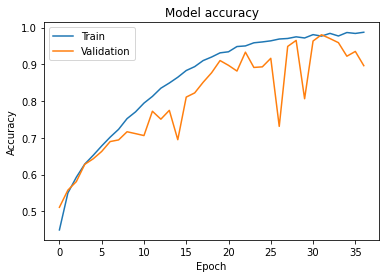

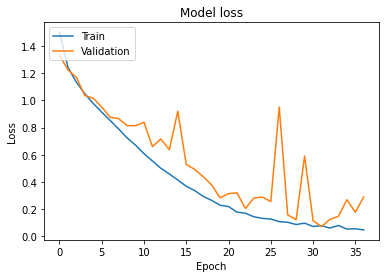

In [27]:
# Plot the accuracy for each epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()